# Twitter Sentiment Analysis

## Analisis de sentimientos utilizando tweets

Este Notebook contiene la implementación para generar un modelo de análisis de sentimientos
utilizando una red neuronal recurrente de tipo _Long Short Term Memory_ asi como el proceso ETL para 
tokenizar las palabras y adecuar el conjunto de entrenamiento.

A continuación se describen los datos del autor original y se realiza la respectiva referencia.

__Autor:__ Paolo Ripamonti -
[Acerca del autor](https://www.kaggle.com/paoloripamonti)

__Notebook:__ Twitter Sentimental Analysis -
[Notebook original](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

El notebook se modifica con el ánimo de realizar este análisis de sentimientos en el lenguaje español
asi como adecuarlo para escalar apropiadamente para su uso en una arquitectura Big Data

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Proyecto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
# dataset_filename = os.listdir("../input")[0]
# dataset_path = os.path.join("..","input",dataset_filename)
dataset_path = 'data/dbm-model-result-2.csv'
print("Open file:", dataset_path)
#df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS, sep=';')
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, sep=';')

Open file: data/dbm-model-result-2.csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 14430


In [6]:
df.head(5)

,target,text,date,ids,user
0,4,"RT @el_pais : ""La misoginia ha hecho que sea e...",Sat Apr 13 06:08:43 +0000 2019,1.116946e+18,alertamachismo
1,4,RT @Med_DipAlmaguer : Ante el aumento de ataqu...,Fri Apr 05 07:46:12 +0000 2019,1.114072e+18,alertamachismo
2,4,RT @guardiacivil : ðMuyUrgenteð´\nCarmen ...,Thu Apr 04 01:14:51 +0000 2019,1.113611e+18,alertamachismo
3,4,RT @GanemoSala : .@alertamachismo @movfeminist...,Thu Apr 04 01:32:45 +0000 2019,1.113615e+18,alertamachismo
4,4,RT @tomasantoniomaz : Por una vida SIN #Violen...,Sat Nov 25 03:51:46 +0000 2017,9.342683e+17,alertamachismo


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 6.01 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

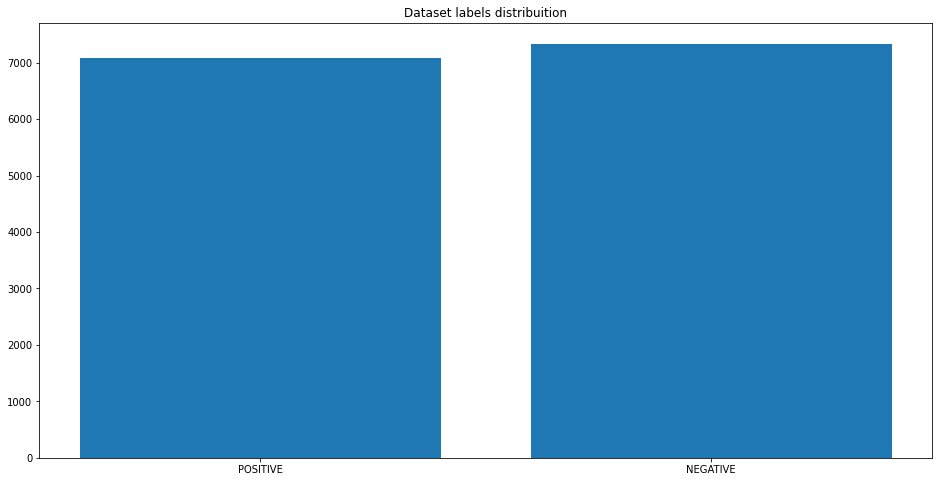

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("spanish")
stemmer = SnowballStemmer("spanish")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1.39 s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 11544
TEST size: 2886


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 22 ms


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-11-16 21:04:27,526 : INFO : collecting all words and their counts
2020-11-16 21:04:27,527 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-16 21:04:27,575 : INFO : PROGRESS: at sentence #10000, processed 201528 words, keeping 28609 word types
2020-11-16 21:04:27,582 : INFO : collected 30888 word types from a corpus of 232532 raw words and 11544 sentences
2020-11-16 21:04:27,583 : INFO : Loading a fresh vocabulary
2020-11-16 21:04:27,599 : INFO : effective_min_count=10 retains 3653 unique words (11% of original 30888, drops 27235)
2020-11-16 21:04:27,600 : INFO : effective_min_count=10 leaves 174441 word corpus (75% of original 232532, drops 58091)
2020-11-16 21:04:27,611 : INFO : deleting the raw counts dictionary of 30888 items
2020-11-16 21:04:27,612 : INFO : sample=0.001 downsamples 28 most-common words
2020-11-16 21:04:27,613 : INFO : downsampling leaves estimated 155036 word corpus (88.9% of prior 174441)
2020-11-16 21:04:27,619 : INFO : esti

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 3653


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-16 21:04:28,313 : INFO : training model with 8 workers on 3653 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-16 21:04:28,417 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-16 21:04:28,425 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-16 21:04:28,429 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-16 21:04:28,431 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-16 21:04:28,437 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-16 21:04:28,438 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-16 21:04:28,443 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-16 21:04:28,444 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-16 21:04:28,445 : INFO : EPOCH - 1 : training on 232532 raw words (155024 effective words) took 0.1s, 1288542 effec

Wall time: 4.4 s


(4961699, 7441024)

In [19]:
#w2v_model.wv.most_similar("Violencia")

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 30889
Wall time: 282 ms


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 308 ms


### Label Encoder 

In [22]:
labels = df_train.target.unique().tolist()
#labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (11544, 1)
y_test (2886, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (11544, 300)
y_train (11544, 1)

x_test (2886, 300)
y_test (2886, 1)


In [25]:
y_train[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1]], dtype=int64)

### Embedding layer

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(30889, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          9266700   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 9,427,201
Trainable params: 160,501
Non-trainable params: 9,266,700
_________________________________________________________________


### Compile model

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
11/11 [==============================] - 64s 6s/step - loss: 0.6874 - accuracy: 0.5458 - val_loss: 0.6710 - val_accuracy: 0.5680
Epoch 2/8
11/11 [==============================] - 65s 6s/step - loss: 0.6702 - accuracy: 0.5786 - val_loss: 0.6544 - val_accuracy: 0.5957
Epoch 3/8
11/11 [==============================] - 67s 6s/step - loss: 0.6572 - accuracy: 0.5980 - val_loss: 0.6505 - val_accuracy: 0.6139
Epoch 4/8
11/11 [==============================] - 70s 6s/step - loss: 0.6472 - accuracy: 0.6116 - val_loss: 0.6463 - val_accuracy: 0.6121
Epoch 5/8
11/11 [==============================] - 76s 7s/step - loss: 0.6429 - accuracy: 0.6164 - val_loss: 0.6431 - val_accuracy: 0.6260
Epoch 6/8
11/11 [==============================] - 80s 7s/step - loss: 0.6364 - accuracy: 0.6252 - val_loss: 0.6377 - val_accuracy: 0.6104
Epoch 7/8
11/11 [==============================] - 83s 8s/step - loss: 0.6318 - accuracy: 0.6253 - val_loss: 0.6355 - val_accuracy: 0.6216
Epoch 8/8
11/11 [==========

### Evaluate

In [32]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

3/3 [==============================] - 2s 754ms/step - loss: 0.6385 - accuracy: 0.6209

ACCURACY: 0.6209286451339722
LOSS: 0.6384827494621277
Wall time: 3.5 s


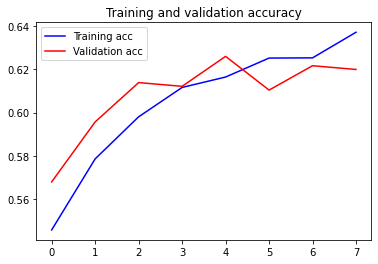

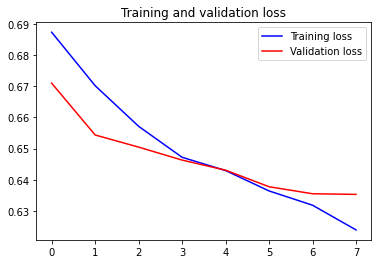

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [34]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [35]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [36]:
predict("Masacre en el cauca deja 10 heridos")

{'label': 'NEUTRAL',
 'score': 0.42131611704826355,
 'elapsed_time': 0.21586918830871582}

In [37]:
predict("Prevencion de la violencia contra la mujer")

{'label': 'NEGATIVE',
 'score': 0.33223211765289307,
 'elapsed_time': 0.0559694766998291}

### Confusion Matrix

In [38]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 0s 2ms/step
Wall time: 2.89 s


In [39]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

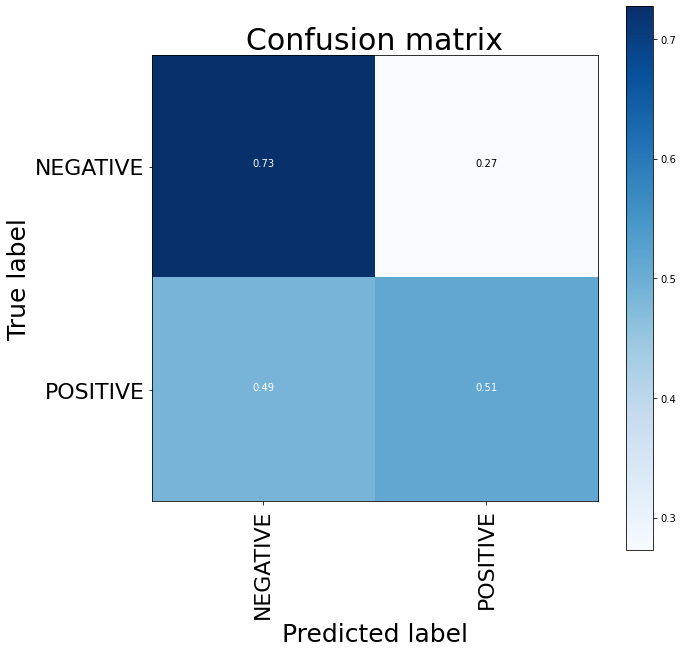

Wall time: 174 ms


In [40]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [41]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.60      0.73      0.66      1455
    POSITIVE       0.65      0.51      0.57      1431

    accuracy                           0.62      2886
   macro avg       0.63      0.62      0.62      2886
weighted avg       0.63      0.62      0.62      2886



### Accuracy Score

In [42]:
accuracy_score(y_test_1d, y_pred_1d)

0.6209286209286209

### Save model

In [43]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-16 21:15:37,293 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-16 21:15:37,294 : INFO : not storing attribute vectors_norm
2020-11-16 21:15:37,294 : INFO : not storing attribute cum_table
2020-11-16 21:15:37,366 : INFO : saved model.w2v
